Deep Learning Project

Twitter US Airline Sentiment Analysis

In [1]:
!pip install hpsklearn
!pip install optuna
!pip install transformers

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.7 MB/s eta 0:00:00
  Created wheel for hpsklearn: filename=hpsklearn-0.1.0-py3-none-any.whl size=23912 sha256=e261aa338009730dcdc86cf0f4b217d2c5e8166938dfcc9f7f6eb41297530730
  Stored in directory: /root/.cache/pip/wheels/17/c9/77/c90583ead12766888d5bd1287f1a459a96c0de450ded17f6d5
Successfully built hpsklearn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [2]:
#Importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk as nl
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.tokenize import word_tokenize
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from hpsklearn import HyperoptEstimator,extra_trees
from hpsklearn import any_regressor
from hpsklearn import any_preprocessing
from hyperopt import tpe
import optuna
import sklearn
from scipy.special import softmax
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch import nn
import torch.nn.functional as F
from numpy import array
!pip install keras_preprocessing
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from sklearn.ensemble import RandomForestClassifier


WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 572.0 kB/s eta 0:00:00


1.Data Collection

In [3]:
tweets_df = pd.read_csv("/content/Tweets.csv")
tweets = tweets_df.copy()

In [4]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


2.Data Preprocessing

In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [6]:
tweets.shape

(14640, 15)

In [7]:
#Exploratory Data Analysis

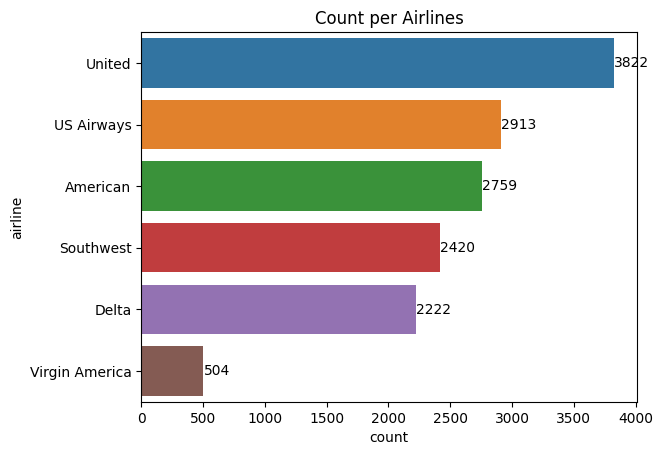

In [8]:
#Total count per Airlines

import seaborn as sns

ax = sns.countplot(data = tweets, y = 'airline',
                   order = tweets.airline.value_counts().index)
ax.bar_label(ax.containers[0])
ax.set_title('Count per Airlines',)

plt.show()

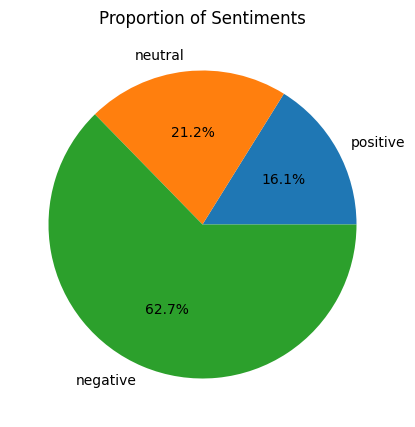

In [9]:
import matplotlib.pyplot as plt

x = tweets['airline_sentiment'].value_counts().sort_values()

plt.figure(figsize=(5, 5))
ax = plt.pie(x=x, labels=x.index, autopct='%1.1f%%')
plt.title('Proportion of Sentiments')

plt.show()


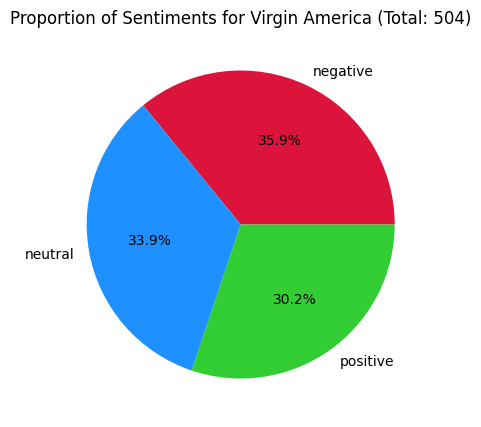

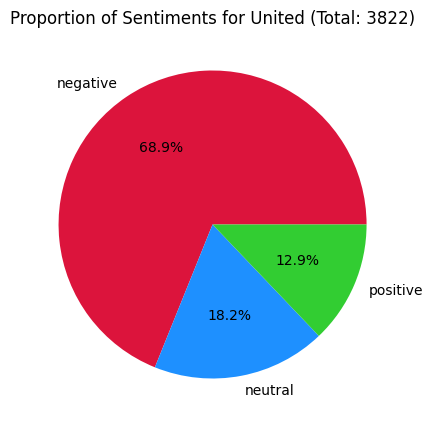

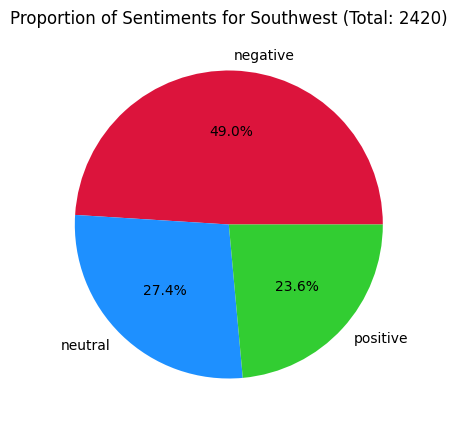

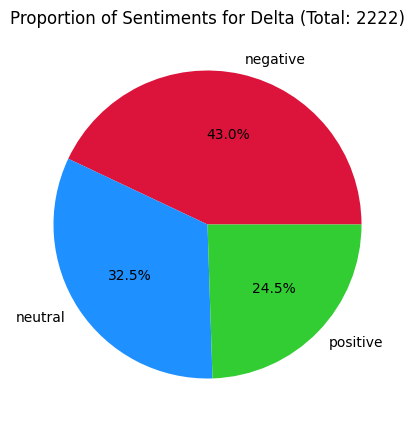

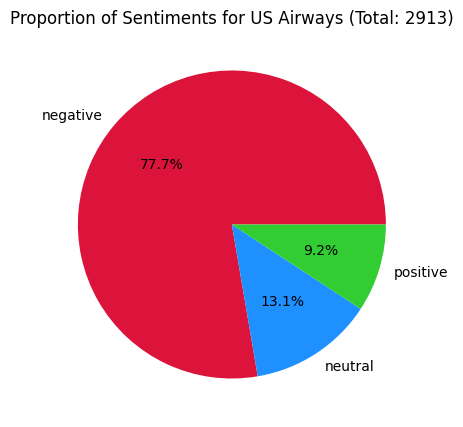

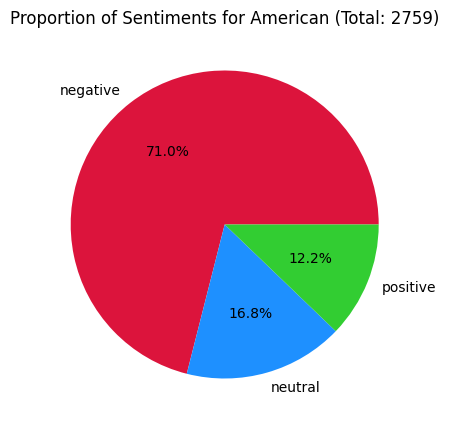

In [10]:
import matplotlib.pyplot as plt

# Define a custom color palette
colors = {'negative': '#DC143C', 'positive': '#32CD32', 'neutral': '#1E90FF'}

airlines = tweets['airline'].unique()

# Loop through each unique airline and create a pie chart for each
for airline in airlines:
    subset = tweets[tweets['airline'] == airline]
    sentiment_counts = subset['airline_sentiment'].value_counts()

    total_values = sentiment_counts.sum()

    plt.figure(figsize=(5, 5))
    ax = plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=[colors[sentiment] for sentiment in sentiment_counts.index])
    plt.title(f'Proportion of Sentiments for {airline} (Total: {total_values})')

    plt.show()


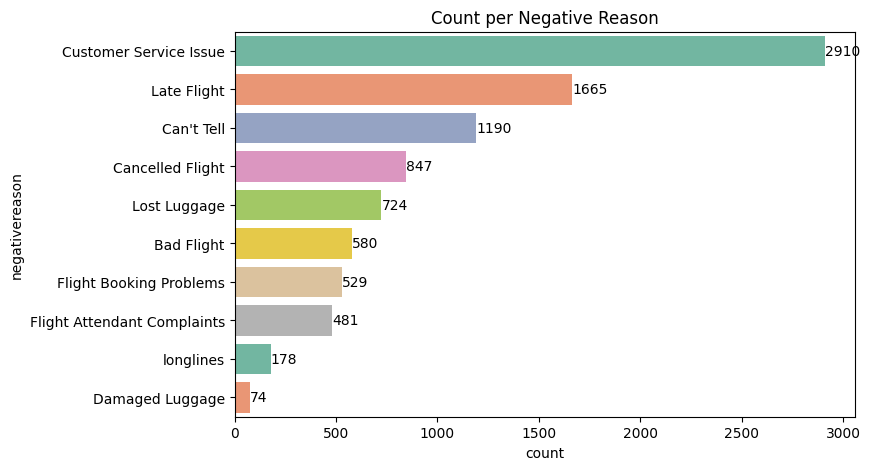

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

df_neg = tweets[tweets['airline_sentiment'] == 'negative']

plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df_neg, y='negativereason',
                   palette='Set2',
                   order=df_neg['negativereason'].value_counts().index)

ax.bar_label(ax.containers[0])
ax.set_title('Count per Negative Reason')

plt.show()


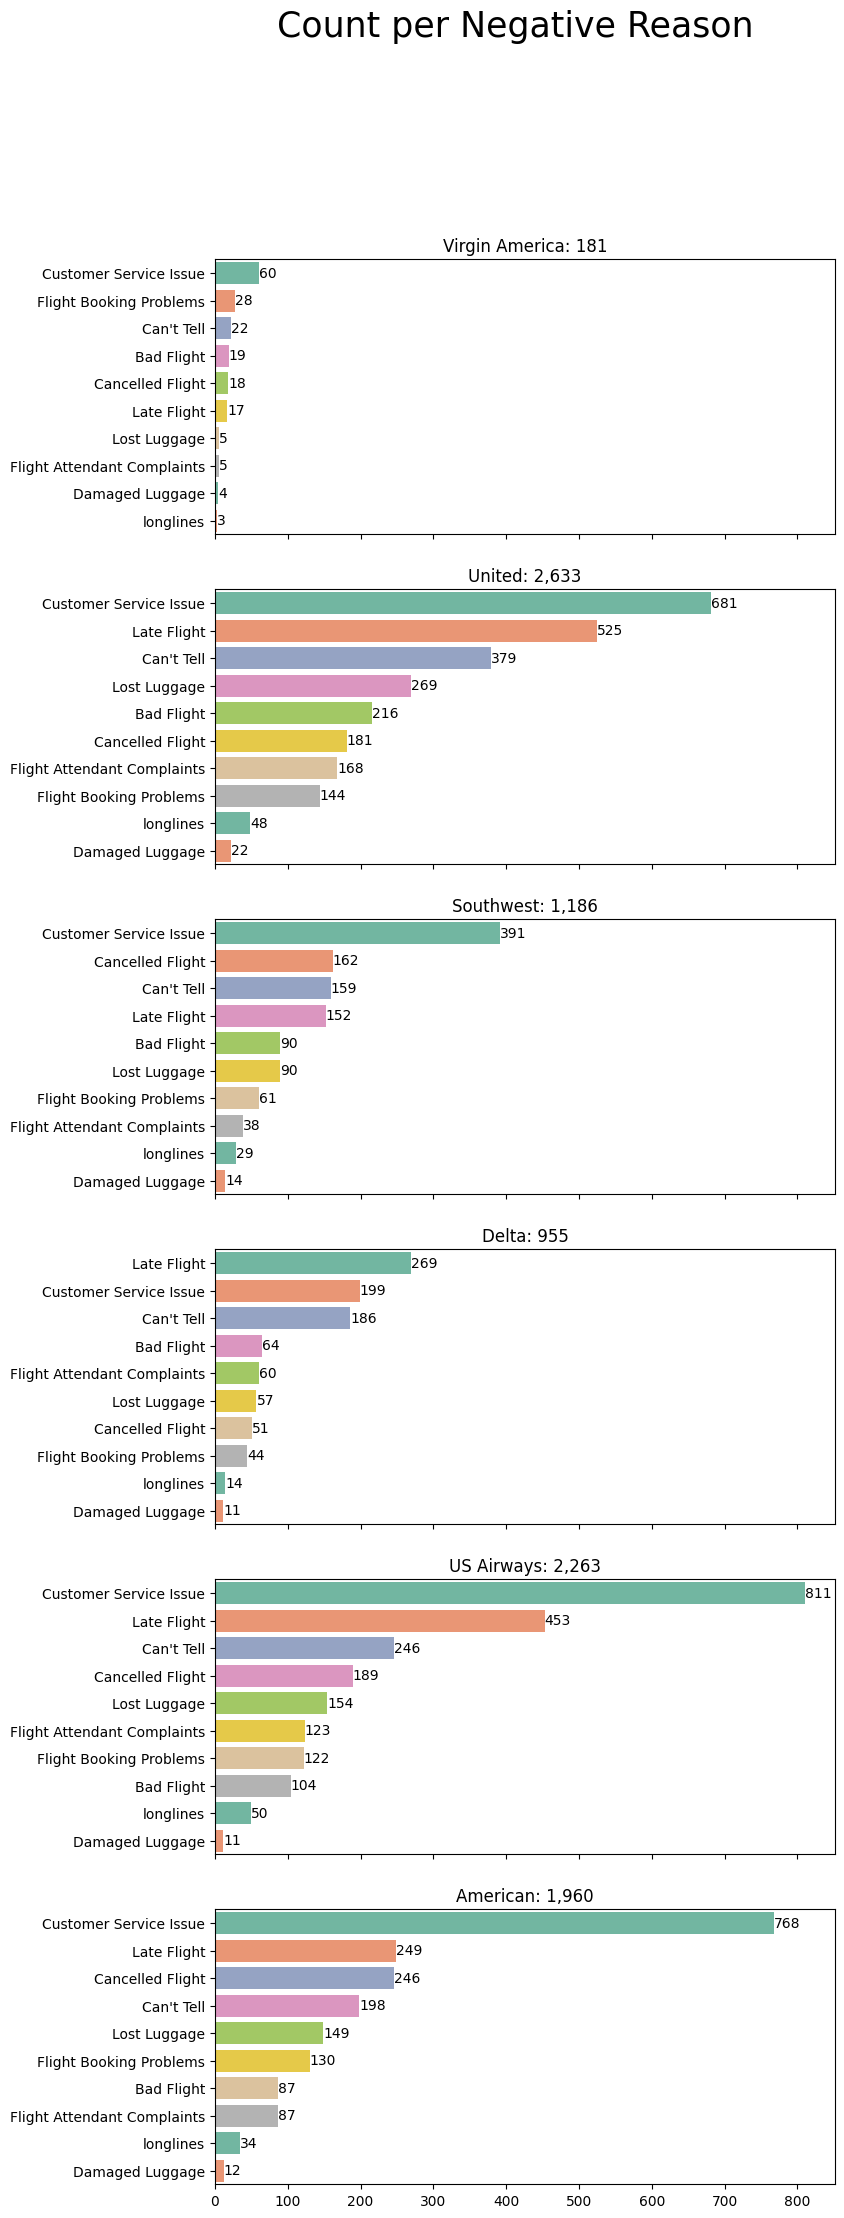

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

df_neg = tweets[tweets['airline_sentiment'] == 'negative']

fig, axes = plt.subplots(len(df_neg['airline'].unique()), 1, figsize=(8, 25), sharex=True)
names = df_neg['airline'].unique()

for name, n in zip(names, axes):
    ax = sns.countplot(data=df_neg[df_neg['airline'] == name], y='negativereason',
                       palette='Set2',
                       order=df_neg[df_neg['airline'] == name]['negativereason'].value_counts().index, ax=n)
    ax.bar_label(ax.containers[0])
    ax.set_title(f"{name}: {format(len(df_neg[df_neg['airline'] == name]), ',')}")
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.suptitle("Count per Negative Reason", fontsize=25)
plt.show()


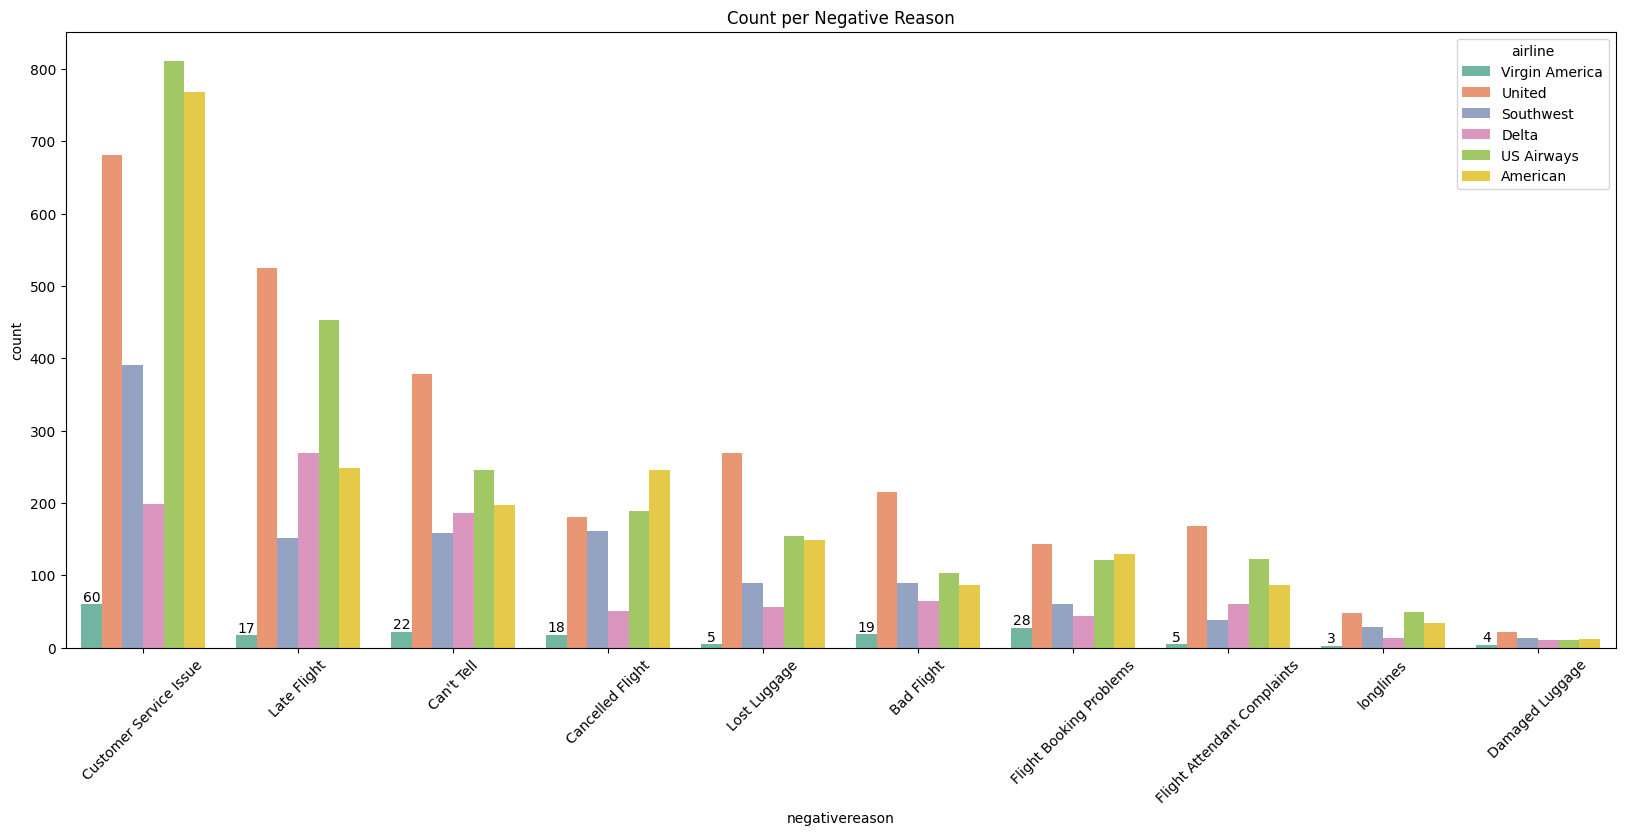

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

df_neg = tweets[tweets['airline_sentiment'] == 'negative']

plt.figure(figsize=(20, 8))
ax = sns.countplot(data=df_neg, x='negativereason',
                   palette='Set2',
                   order=df_neg['negativereason'].value_counts().index, hue='airline')

ax.bar_label(ax.containers[0])
ax.set_title('Count per Negative Reason')
plt.xticks(rotation=45)
plt.show()


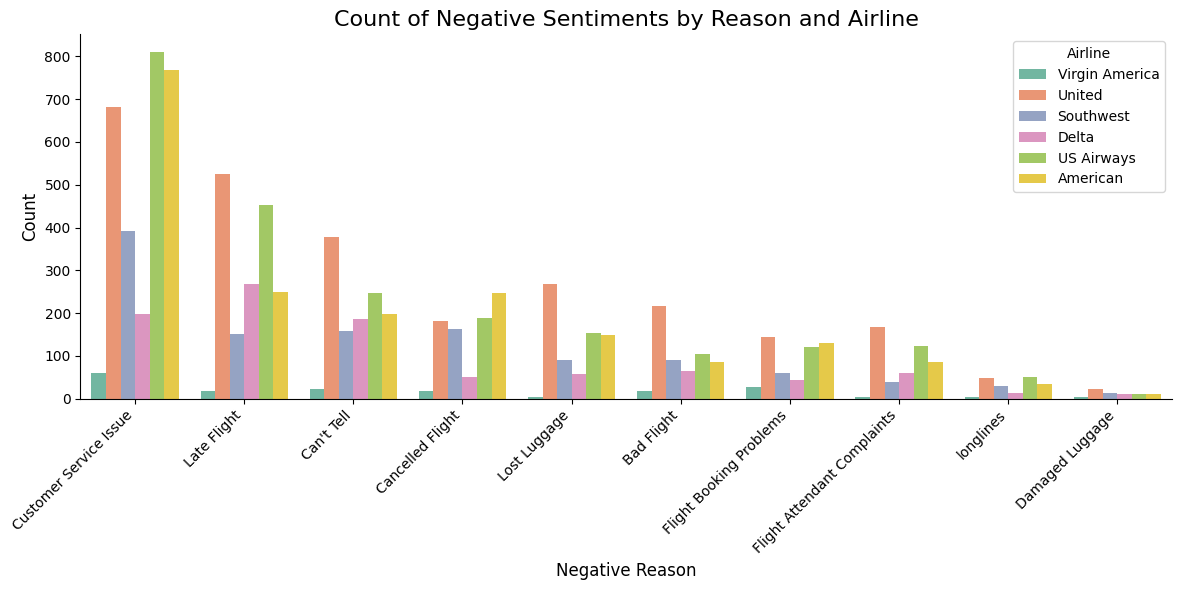

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

df_neg = tweets[tweets['airline_sentiment'] == 'negative']

plt.figure(figsize=(12, 6))

# Create the count plot with Seaborn
ax = sns.countplot(data=df_neg, x='negativereason',
                   palette='Set2',
                   order=df_neg['negativereason'].value_counts().index, hue='airline')

# Set the title
plt.title('Count of Negative Sentiments by Reason and Airline', fontsize=16)

# Label the axes
ax.set_xlabel('Negative Reason', fontsize=12)
ax.set_ylabel('Count', fontsize=12)

# Rotate x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Add a legend
ax.legend(title='Airline', loc='upper right')

# Remove column values from bars
for p in ax.patches:
    ax.annotate('', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='white', xytext=(0, 5),
                textcoords='offset points')

# Improve spacing and aesthetics
sns.despine()
plt.tight_layout()

plt.show()



<Axes: title={'center': 'Number of tweets per day'}, xlabel='tweet_created'>

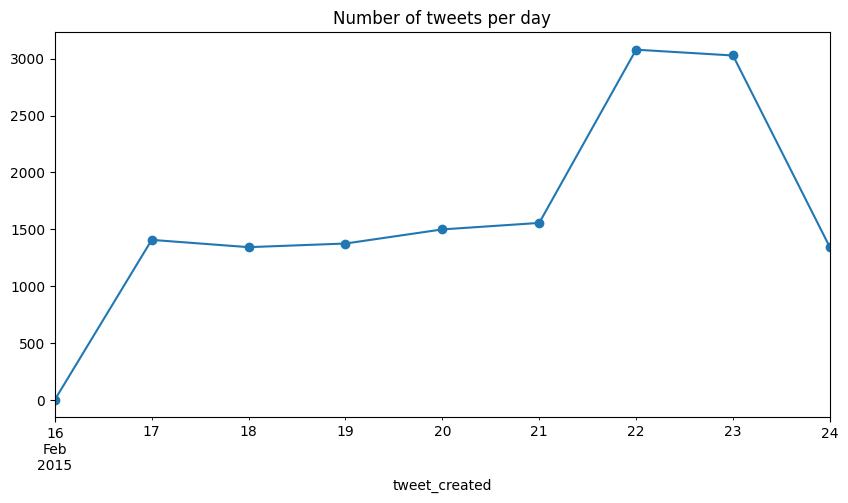

In [15]:
#Number of tweets per day (All airlines)

tweets['tweet_created'] = pd.to_datetime(tweets['tweet_created'])
tweets_time_index = tweets.copy()
tweets_time_index.set_index("tweet_created", inplace=True)

tweets_time_index.resample("D")['tweet_id'].count().plot(style="-o", figsize=(10, 5), title="Number of tweets per day")

<ipython-input-16-d1096d6c99d9>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tweets_time_index.resample("D").sum().plot(style="-o", figsize=(10, 5),title="Number of Daily Tweets by Airline")


<Axes: title={'center': 'Number of Daily Tweets by Airline'}, xlabel='tweet_created'>

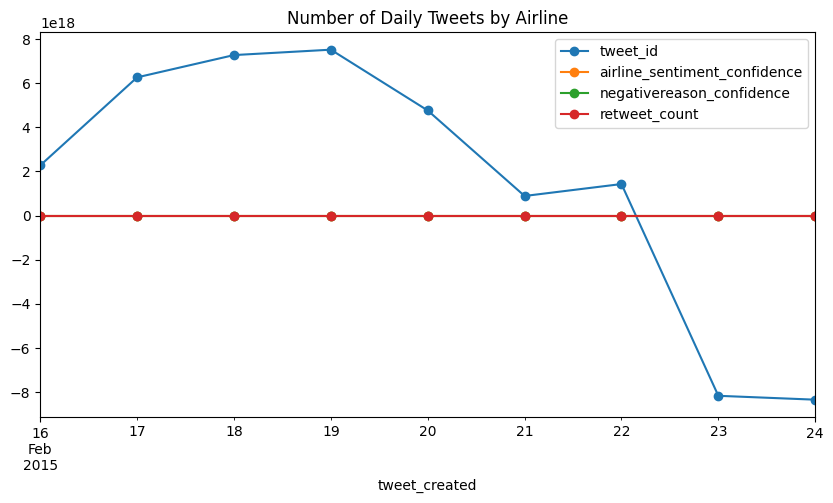

In [16]:
#Number of Daily Tweets by Airline

tweets_time_index.resample("D").sum().plot(style="-o", figsize=(10, 5),title="Number of Daily Tweets by Airline")

3.Data Preparation

In [17]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
# Create a copy of the original DataFrame 'tweets_df' to perform text cleaning and preprocessing
text_cleaning_df = tweets_df.copy()

# Define a list of common English stopwords to be used for text cleaning
stop_words = stopwords.words('english')

# Initialize a stemming algorithm, such as the Porter Stemmer, to reduce words to their root form
porter = PorterStemmer()


In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [20]:
#Text Preprocessing and Feature Engineering

# Tokenised Text
text_cleaning_df['word_tokenized_text'] = text_cleaning_df['text'].apply(lambda x: word_tokenize(x))

# Remove Puntuation
text_cleaning_df['word_remove_puntuation_text'] = text_cleaning_df['word_tokenized_text'].apply(lambda x: [w for w in x if w.isalpha()])

# Lower Case the all words
text_cleaning_df['lower_text'] = text_cleaning_df['word_remove_puntuation_text'].apply(lambda x: [w.lower() for w in x])

# Trimed leading and trailing spaces
text_cleaning_df['space_trimmed_text'] = text_cleaning_df['lower_text'].apply(lambda x: [w.strip() for w in x])

# Remove Stop words
text_cleaning_df['stop_words_removed_text'] = text_cleaning_df['space_trimmed_text'].apply(lambda x: [w for w in x if w not in stop_words])

# Steam Text
text_cleaning_df['stemmed_text'] = text_cleaning_df['stop_words_removed_text'].apply(lambda x: [porter.stem(w) for w in x])

# Check if specific word exist in tweets
text_cleaning_df['is_love'] = text_cleaning_df['stemmed_text'].apply(lambda x: 1 if 'love' in x else 0)
text_cleaning_df['is_good'] = text_cleaning_df['stemmed_text'].apply(lambda x: 1 if 'good' in x else 0)
text_cleaning_df['is_bad'] = text_cleaning_df['stemmed_text'].apply(lambda x: 1 if 'bad' in x else 0)

# Add processed setennce size
text_cleaning_df['sentence_size'] = text_cleaning_df['stemmed_text'].apply(lambda x: len(x))
text_cleaning_df['processed_text'] = text_cleaning_df['stemmed_text'].apply(lambda x: " ".join(x))

# Remove Neutral Data from dataset
text_cleaning_df = text_cleaning_df[(text_cleaning_df['airline_sentiment'] != 'neutral')]

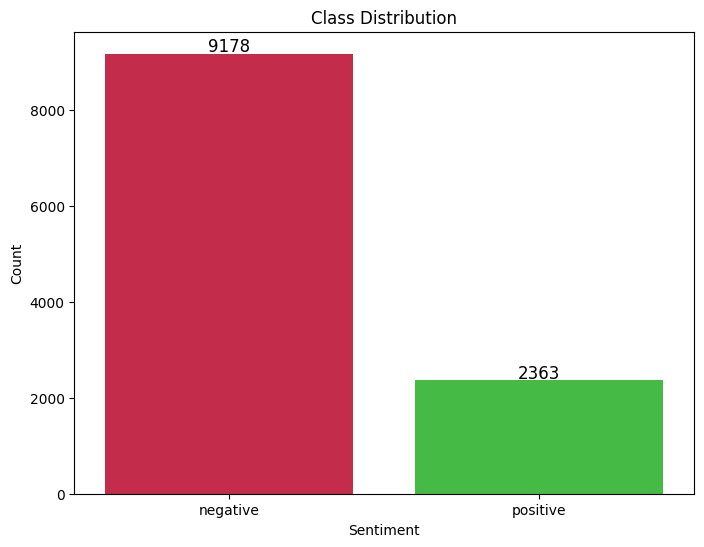

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of samples for each class
class_counts = text_cleaning_df['airline_sentiment'].value_counts()

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values,palette=colors)

colors = {'positive': '#32CD32', 'negative': '#DC143C'}

# Add labels to the bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Set the title and labels
plt.title('Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Show the bar plot
plt.show()


In [22]:
#The data is imbalanced

In [23]:
#Fixing Data Imbalance

#To balance the dataset by matching the number of 'negative' sentiment rows with 'positive' sentiment rows

# Select rows with 'positive' sentiment from the cleaned dataset
positive_sentiment_df = text_cleaning_df[text_cleaning_df['airline_sentiment'] == 'positive']

# Create a balanced dataset by randomly sampling 'negative' sentiment rows to match the size of 'positive' sentiment rows
# This ensures a balanced distribution of positive and negative sentiment data
negative_sentiment_index = text_cleaning_df[text_cleaning_df['airline_sentiment'] == 'negative'].sample(positive_sentiment_df.shape[0]).index

# Extract the 'negative' sentiment rows using the sampled index
negative_sentiment_df = text_cleaning_df.loc[negative_sentiment_index]

# Combine the 'positive' and 'negative' sentiment rows to create a balanced dataset
balanced_dataset_df = positive_sentiment_df.append(negative_sentiment_df, ignore_index=True)


<ipython-input-23-e664f2b015f7>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_dataset_df = positive_sentiment_df.append(negative_sentiment_df, ignore_index=True)


In [24]:
#Print the counts of how many tweets in the balanced dataset contain the words 'love,' 'good,' and 'bad' for analysis.

print(f"contains love: {balanced_dataset_df['is_love'].sum()}", f"contains good: {balanced_dataset_df['is_good'].sum()}", f"contains bad: {balanced_dataset_df['is_bad'].sum()}")

contains love: 183 contains good: 146 contains bad: 42


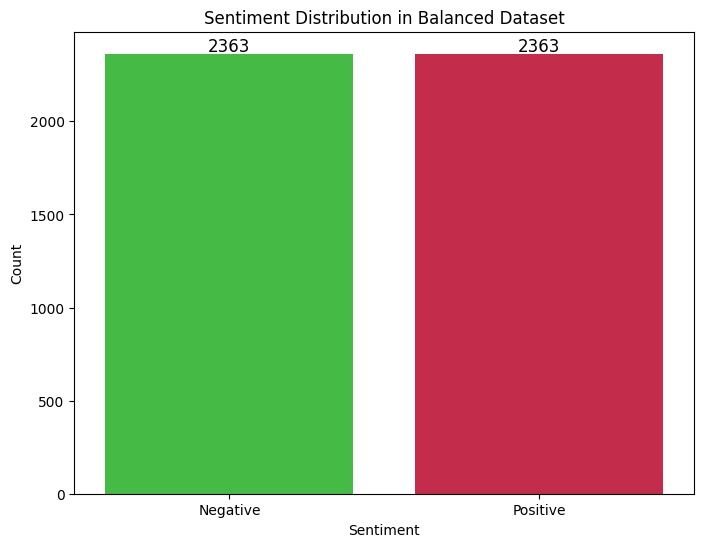

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of samples for each sentiment class
sentiment_counts = balanced_dataset_df['airline_sentiment'].value_counts()

# Define a custom color palette for the plot
colors = {'positive': '#32CD32', 'negative': '#DC143C'}

# Create a bar plot to visualize the class distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=balanced_dataset_df, x='airline_sentiment', palette=colors, order=sentiment_counts.index)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Set the title and labels
plt.title('Sentiment Distribution in Balanced Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Customize x-axis labels
ax.set_xticklabels(['Negative', 'Positive'])

# Show the bar plot
plt.show()


In [26]:
#The dataset is now balanced

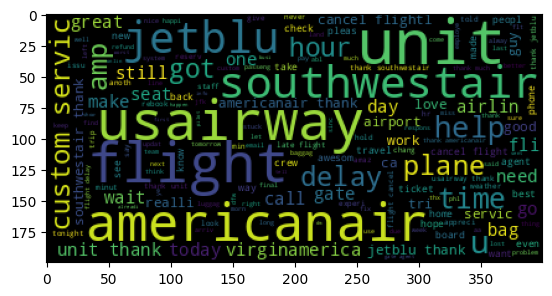

In [27]:
#Visualize the Maximum Repeated Words

# Concatenate all processed texts into a single string
text = " ".join(balanced_dataset_df['processed_text'].values)

# Generate a word cloud with a maximum font size of 50
wordcloud = WordCloud(max_font_size=50).generate(text)

# Display the word cloud
plt.imshow(wordcloud)
plt.show()

In [28]:
#Embed Words using Tfidf Algorithm

# Create a TfidfVectorizer to convert text data into numerical features
vectorizer = TfidfVectorizer()

# Fit and transform the processed text data to obtain a feature matrix
X = vectorizer.fit_transform(balanced_dataset_df['processed_text'].values)

# Print the number of features obtained after Tfidf transformation
print(len(vectorizer.get_feature_names_out()))


4835


In [29]:
#Label Encoding

label_encoder = LabelEncoder()

training_df = balanced_dataset_df.copy()
y = training_df['airline_sentiment']
y = label_encoder.fit_transform(y.astype('str'))

In [30]:
# Split the dataset into training and testing sets
# X_train and X_test are the feature vectors
# y_train and y_test are the corresponding labels
# The data is split into 67% for training and 33% for testing
# Setting a random seed (random_state) for reproducibility

# Set a fixed random seed value
random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.33, random_state=1)


In [31]:
print(X_train.shape)
print(y_train.shape)

(3166, 4835)
(3166,)


4.Model Building

In [49]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


def evaluate_classifier(classifier, X_train, y_train, X_test, y_test):
    # Train the classifier on the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = classifier.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print performance metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)


rf_classifier = RandomForestClassifier(n_estimators=700, max_depth=10, random_state=1)
svm_classifier = SVC(C=0.001, degree=1)
logistic_regression = LogisticRegression(C=0.001, penalty='l2', max_iter=100)
nb_classifier = GaussianNB()

# Evaluate each classifier
print("Random Forest Classifier:")
evaluate_classifier(rf_classifier, X_train, y_train, X_test, y_test)

print("\nSVM Classifier:")
evaluate_classifier(svm_classifier, X_train, y_train, X_test, y_test)

print("\nLogistic Regression:")
evaluate_classifier(logistic_regression, X_train, y_train, X_test, y_test)

print("\nNaive Bayes Classifier:")
evaluate_classifier(nb_classifier, X_train, y_train, X_test, y_test)


Random Forest Classifier:
Accuracy: 0.7097791798107256
Precision: 0.7434944237918215
Recall: 0.6349206349206349
F1 Score: 0.684931506849315

SVM Classifier:
Accuracy: 0.638801261829653
Precision: 0.6869565217391305
Recall: 0.5015873015873016
F1 Score: 0.5798165137614679

Logistic Regression:
Accuracy: 0.6230283911671924
Precision: 0.6386861313868614
Recall: 0.5555555555555556
F1 Score: 0.5942275042444821

Naive Bayes Classifier:
Accuracy: 0.5473186119873817
Precision: 0.5259259259259259
Recall: 0.9015873015873016
F1 Score: 0.6643274853801169


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [33]:
#CNN

In [34]:
!pip install keras.layers.convolutional

ERROR: Could not find a version that satisfies the requirement keras.layers.convolutional (from versions: none)
ERROR: No matching distribution found for keras.layers.convolutional


In [35]:
# Word Embedding

# Define vocabulary size and maximum sequence length
vocab_size = 4788
max_length = 22

# Extract the target variable and perform label encoding
y = balanced_dataset_df['airline_sentiment']
y = label_encoder.fit_transform(y)

# Extract and preprocess the text data
X = balanced_dataset_df['processed_text']

# Split the data into training and testing sets with a 33% test size and a random seed of 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# Perform one-hot encoding on the training data and pad sequences to a fixed length
encoded_docs = [one_hot(d, vocab_size) for d in X_train.values]
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Split your data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_docs, y_train, test_size=0.2, random_state=1)

# Create a Sequential model for Convolutional Neural Network (CNN)
cnn_model = Sequential()

# Add an Embedding layer with vocabulary size, embedding dimension, and input length
cnn_model.add(Embedding(vocab_size, 100, input_length=max_length))

# Add a Convolutional layer with 128 filters, kernel size 5, and ReLU activation
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Add a MaxPooling layer with pool size 2
cnn_model.add(MaxPooling1D(pool_size=2))

# Add another Convolutional layer with 64 filters, kernel size 3, and ReLU activation
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

# Add another MaxPooling layer with pool size 2
cnn_model.add(MaxPooling1D(pool_size=2))

# Flatten the output from convolutional layers
cnn_model.add(Flatten())

# Add a Dense layer with 128 units and ReLU activation
cnn_model.add(Dense(128, activation='relu'))

# Add a Dropout layer to prevent overfitting
cnn_model.add(Dropout(0.5))

# Add the output layer with 1 unit and sigmoid activation for binary classification
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model's architecture
print(cnn_model.summary())




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 100)           478800    
                                                                 
 conv1d (Conv1D)             (None, 18, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 9, 128)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 64)             0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 192)               0

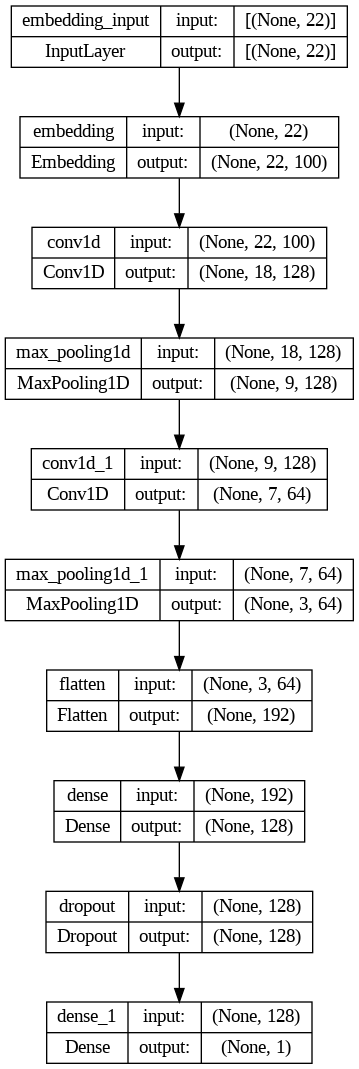

In [37]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import plot_model  # Import the plot_model function
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Plot the model architecture with shapes
plot_model(cnn_model, show_shapes=True)

In [38]:
# Train the CNN model on the training data with 5 epochs
# Display training progress with verbose mode enabled (verbose=1)
# Also, validate the model on the test data during training
history = cnn_model.fit(X_train, y_train, epochs=5, verbose=1, validation_data=(X_test, y_test))

Epoch 1/5
80/80 [==============================] - 4s 34ms/step - loss: 0.5673 - accuracy: 0.6927 - val_loss: 0.4345 - val_accuracy: 0.7965
Epoch 2/5
80/80 [==============================] - 3s 37ms/step - loss: 0.2736 - accuracy: 0.8870 - val_loss: 0.3905 - val_accuracy: 0.8297
Epoch 3/5
80/80 [==============================] - 3s 38ms/step - loss: 0.1294 - accuracy: 0.9605 - val_loss: 0.4862 - val_accuracy: 0.8233
Epoch 4/5
80/80 [==============================] - 3s 37ms/step - loss: 0.0537 - accuracy: 0.9834 - val_loss: 0.7081 - val_accuracy: 0.8123
Epoch 5/5
80/80 [==============================] - 3s 36ms/step - loss: 0.0400 - accuracy: 0.9846 - val_loss: 0.8846 - val_accuracy: 0.8028


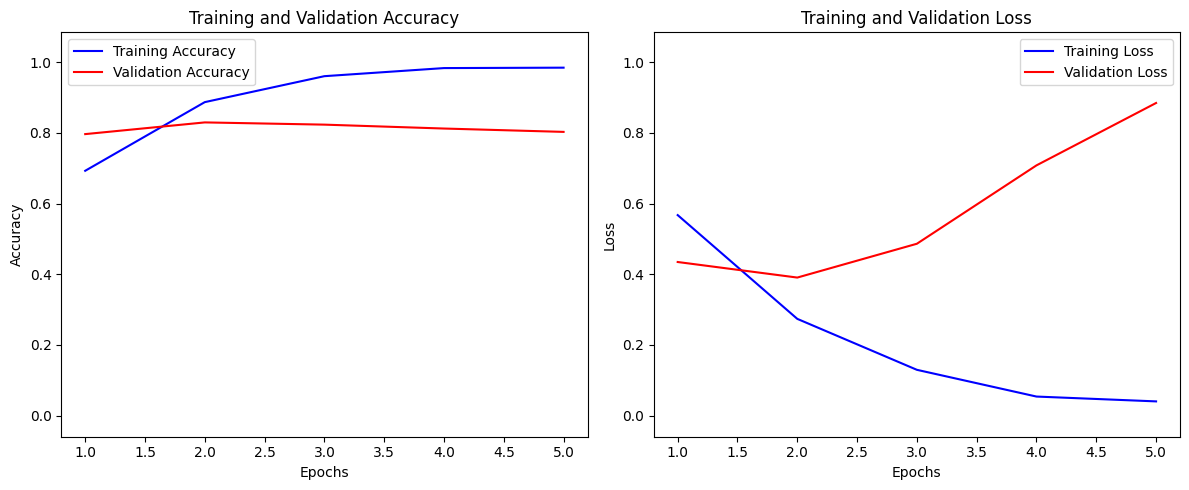

In [39]:
import matplotlib.pyplot as plt

# Extract training accuracy, validation accuracy, training loss, and validation loss from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs for the x-axis
epochs = range(1, len(train_accuracy) + 1)

# Set custom limits for the y-axis
y_min = min(min(train_accuracy), min(val_accuracy), min(train_loss), min(val_loss))
y_max = max(max(train_accuracy), max(val_accuracy), max(train_loss), max(val_loss))

# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(y_min - 0.1, y_max + 0.1)  # Set custom y-axis limits

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(y_min - 0.1, y_max + 0.1)  # Set custom y-axis limits

plt.tight_layout()
plt.show()


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate predictions for your CNN model
y_prob = cnn_model.predict(X_test)
y_pred = (y_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_prob)

# Print the individual metrics
print("CNN:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)




20/20 [==============================] - 2s 14ms/step
CNN:
Accuracy: 0.8028391167192429
Precision: 0.802547770700637
Recall: 0.8
F1 Score: 0.8012718600953895
ROC AUC: 0.8891824650445339


5.Model Evaluation

In [50]:
import pandas as pd

# Define the data
data = {
    "Classifier": ["Random Forest", "SVM", "Logistic Regression", "Naive Bayes", "CNN"],
    "Accuracy": [0.7097791798107256, 0.638801261829653, 0.6230283911671924, 0.5473186119873817, 0.8028391167192429],
    "Precision": [0.7434944237918215, 0.6869565217391305, 0.6386861313868614, 0.5259259259259259, 0.802547770700637],
    "Recall": [0.6349206349206349, 0.5015873015873016, 0.5555555555555556, 0.9015873015873016, 0.8],
    "F1 Score": [0.684931506849315, 0.5798165137614679, 0.5942275042444821, 0.6643274853801169, 0.8012718600953895]
}


# Create a DataFrame
df = pd.DataFrame(data)

# Sort the DataFrame by accuracy in ascending order
df2 = df.sort_values(by="Accuracy", ascending=False)

# Display the sorted DataFrame
df2


,Classifier,Accuracy,Precision,Recall,F1 Score
4,CNN,0.802839,0.802548,0.800000,0.801272
0,Random Forest,0.709779,0.743494,0.634921,0.684932
1,SVM,0.638801,0.686957,0.501587,0.579817
2,Logistic Regression,0.623028,0.638686,0.555556,0.594228
3,Naive Bayes,0.547319,0.525926,0.901587,0.664327


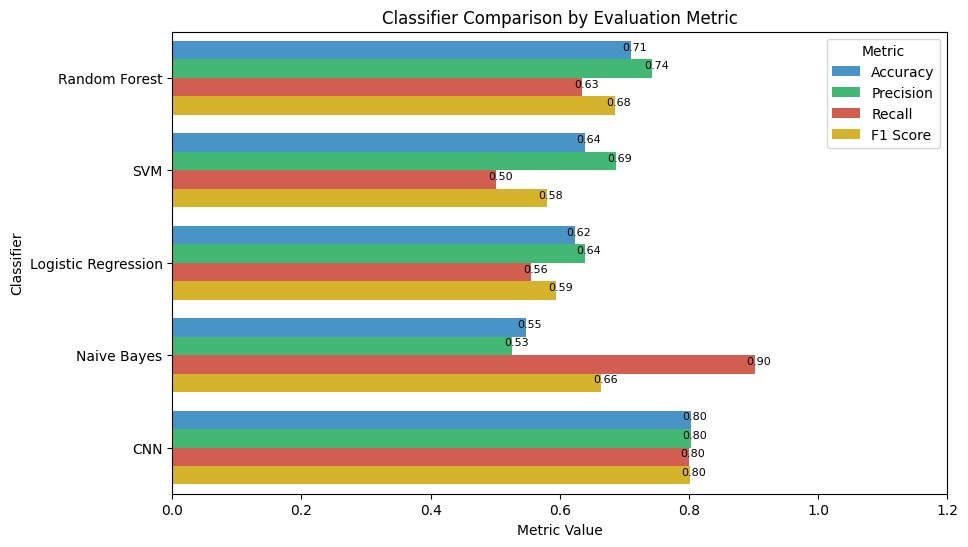

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Set the figure size for better visibility
plt.figure(figsize=(10, 6))

# Define the metrics to plot
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

# Reorganize the data for a horizontal grouped bar chart
melted_df = pd.melt(df, id_vars="Classifier", value_vars=metrics, var_name="Metric")

# Set a custom color palette for the metrics
color_palette = ["#3498db", "#2ecc71", "#e74c3c", "#f1c40f"]

# Plot a horizontal grouped bar chart using seaborn
ax = sns.barplot(data=melted_df, x="value", y="Classifier", hue="Metric", palette=color_palette)

# Add data labels to the bars with smaller font size
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height() / 2.), ha='center', fontsize=8, color='black', xytext=(3, 0), textcoords='offset points')

# Add labels and title
plt.xlabel("Metric Value")
plt.ylabel("Classifier")
plt.title("Classifier Comparison by Evaluation Metric")

# Set x-axis limits for cleaner presentation
plt.xlim(0, 1.2)

# Show the chart
plt.legend(title="Metric", loc="upper right")
plt.show()

In [52]:
#CNN has the best overall performance for sentiment analysis

In [53]:
# Save the trained CNN model to a file
cnn_model.save("cnn_model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
